In [3]:
## STANDARD PYTHON LIBS
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

cuda_version = os.popen("cat /usr/local/cuda/version.txt ").read()
print ('TF : ', tf.__version__, '  Keras : ', keras.__version__, '  CUDA : ', cuda_version)

TF :  1.6.0   Keras :  2.1.5   CUDA :  CUDA Version 9.0.176



In [19]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
if 'src.utils'     in sys.modules : del sys.modules['src.utils']
if 'src.model'     in sys.modules : del sys.modules['src.model']

import src.utils as utils
import src.model as modellib
import src.mapillary as mapillary

if __name__ == "__main__":
    url_dataset = '/home/play/datasets/open_datasets/mapillary'
    mapillary_mapper = '/home/play/playment/Mask_RCNN/demo/raw/merge__cityscapes_mapillary_v2.json'
    mapillary_config = mapillary.MapillaryConfig(images_per_gpu=16, gpu_count=1)
    print (mapillary_config.BATCH_SIZE)
    trainData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'train')
    valData   = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'val')
    

16
Mode : train has 17979 images
Mode : val has 2000 images


In [ ]:
import h5py
import time

def create_hdf5(generator, url_dataset, counter):
    print ('Saving in dir : ', url_dataset)
    iters = 0
    while True:
        t0 = time.time()
        url_tmp = os.path.join(url_dataset, '{}.h5'.format(iters))
        data = next(generator)
        if len(data) == 2:
            ip = data[0]
            op = data[1]
        with h5py.File(url_tmp, "w") as hf:
            for i, each in enumerate(ip):
                hf.create_dataset('input_{0}'.format(i), data=each)
            if len(op):
                for i, each in enumerate(op):
                    hf.create_dataset('output_{0}'.format(i), data=each)
            else:
                hf.create_dataset('output'.format(i), data=op)

        print (' -------> Time taken for save : {0} || URL : {1}'.format(round(time.time() - t0,2), iters))
        iters += 1
        if iters > counter:
            break

print ('mapillary_config.BATCH_SIZE : ', mapillary_config.BATCH_SIZE)
val_generator = modellib.data_generator(valData, mapillary_config, shuffle=True, batch_size=mapillary_config.BATCH_SIZE)
url_dataset_val = '/home/play/datasets/open_datasets/mapillary_hdf5_16/mapillary-vistas-dataset_public_v1.0/validation'
if os.patht.exists(url_dataset_val):
    create_hdf5(val_generator, url_dataset_val, counter = 250)

mapillary_config.BATCH_SIZE :  16
Saving in dir :  /home/play/datasets/open_datasets/mapillary_hdf5_16/mapillary-vistas-dataset_public_v1.0/validation
 -------> Time taken for save : 126.28 || URL : 0
 ----> Time Taken for one batch 126.27 || Final Index : 15
 -------> Time taken for save : 133.01 || URL : 1
 ----> Time Taken for one batch 133.01 || Final Index : 31
 -------> Time taken for save : 101.17 || URL : 2
 ----> Time Taken for one batch 101.17 || Final Index : 47
 -------> Time taken for save : 93.89 || URL : 3
 ----> Time Taken for one batch 93.89 || Final Index : 63
 -------> Time taken for save : 119.77 || URL : 4
 ----> Time Taken for one batch 119.77 || Final Index : 79
 -------> Time taken for save : 124.02 || URL : 5
 ----> Time Taken for one batch 124.02 || Final Index : 95
 -------> Time taken for save : 94.32 || URL : 6
 ----> Time Taken for one batch 94.32 || Final Index : 111
 -------> Time taken for save : 105.94 || URL : 7
 ----> Time Taken for one batch 105.95 

 -------> Time taken for save : 130.83 || URL : 74
 ----> Time Taken for one batch 130.83 || Final Index : 1199
 -------> Time taken for save : 96.14 || URL : 75
 ----> Time Taken for one batch 96.14 || Final Index : 1215
 -------> Time taken for save : 114.42 || URL : 76
 ----> Time Taken for one batch 114.42 || Final Index : 1231
 -------> Time taken for save : 79.98 || URL : 77
 ----> Time Taken for one batch 79.98 || Final Index : 1247
 -------> Time taken for save : 88.58 || URL : 78
 ----> Time Taken for one batch 88.58 || Final Index : 1263
 -------> Time taken for save : 113.48 || URL : 79
 ----> Time Taken for one batch 113.48 || Final Index : 1279
 -------> Time taken for save : 115.09 || URL : 80
 ----> Time Taken for one batch 115.09 || Final Index : 1295
 -------> Time taken for save : 104.99 || URL : 81
 ----> Time Taken for one batch 104.99 || Final Index : 1311
 -------> Time taken for save : 111.15 || URL : 82
 ----> Time Taken for one batch 111.15 || Final Index : 132

# CONVERT TO 64.h5

In [4]:
url_dataset_train = '/home/ubuntu/datasets/open_datasets/mapillary_hdf5_16/mapillary-vistas-dataset_public_v1.0/validation'
url_dataset_save  = '/home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/'

idx_read, idx_save = 0, 0
blobs_set_64      = []
blobsize_original = 16
blobsize_target   = 64
blobsize_iters    = blobsize_target//blobsize_original

if os.path.exists(url_dataset_train) and os.path.exists(url_dataset_save):
    files = os.listdir(url_dataset_train)
    for path_iter, file in enumerate(files):
        # 1. EXTRACT FILE
        url_tmp_read = os.path.join(url_dataset_train, file)
        with h5py.File(url_tmp_read, "r") as hf:
            ip, op = [], []
            for name in hf:
                if 'input' in name:
                    ip.append(np.array(hf.get(name)))
        blobs_set_64.append(ip)
        idx_read += 1
        
        # 2. process a bunch of files
        if idx_read % (blobsize_iters) == 0: #gathered 64 items
            res = [[] for k in range(len(blobs_set_64[0]))]
            for i in range(len(res)):
                res_tmp = []
                for blob in blobs_set_64:
                    res[i].extend(blob[i])
                res[i] = np.array(res[i])
            
            #for res_tmp in res:
            #    print (res_tmp.shape)
            
            # 2.1 STORE THIS
            url_tmp_save = os.path.join(url_dataset_save, '{0}.h5'.format(idx_save))
            print ('------> URL : ', url_tmp_save, ' Iter : ', path_iter, '/', len(files))
            with h5py.File(url_tmp_save, "w") as hf:
                for i, each in enumerate(res):
                    hf.create_dataset('input_{0}'.format(i), data=each)
                hf.create_dataset('output'.format(i), data=[])
                
            idx_read =  0
            idx_save += 1 
            blobs_set_64 = []

------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/0.h5  Iter :  3 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/1.h5  Iter :  7 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/2.h5  Iter :  11 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/3.h5  Iter :  15 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/4.h5  Iter :  19 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/5.h5  Iter :  23 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/6.h5  Iter :  27 / 251
------> URL :  /home/u

------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/58.h5  Iter :  235 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/59.h5  Iter :  239 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/60.h5  Iter :  243 / 251
------> URL :  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_64/mapillary-vistas-dataset_public_v1.0/validation/61.h5  Iter :  247 / 251


# GENERATOR

In [5]:
def data_generator(url_dataset):
    while True:
        for each in os.listdir(dataset):
            url_tmp = os.path.join(url_dataset_train, each)
            ip, op = [], []
            print (url_tmp)
            with h5py.File(url_tmp, "r") as hf:
                ip, op = [], []
                for name in hf:
                    if 'input' in name:
                        ip.append(np.array(hf.get(name)))
                    elif 'output' in name:
                        op.append(np.array(hf.get(name)))
            yield ip, op[0]

gen = data_generator('', '')

In [6]:
next(gen)

NameError: name 'url_dataset_train' is not defined

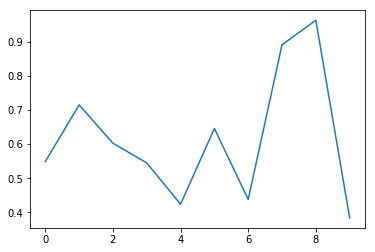

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

np.random.seed(0)
plt.plot(np.random.rand(10));